# Classification on the Titanic Dataset

The following example gives an idea about how you could run basic classification using a Gaussian mixture model on the Titanic dataset, using a latent node, continuous variables as well as discrete variables. The example uses cross validation to get a more robust accuracy score across the training and testing data sets.

The initial step is our imports, and a bit of code for extracting floor and room number.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re

import sys
sys.path.append("../../../bayespy")
import bayespy
import bayespy.visual

import logging
import os
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score

pattern = re.compile("([A-Z]{1})([0-9]{1,3})")

def get_cabin_floor_and_number(cabin):
    if not isinstance(cabin, str):
        return "", np.nan

    cabins = cabin.split(" ")
    for cabin in cabins:
        match = re.match(pattern, cabin)
        if match is not None:
            floor = match.group(1)
            number = match.group(2)

            return floor, number
    return "", np.nan


logger = logging.getLogger()
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

The first step is a bit of preprocessing to get the data in the required format.

In [2]:
db_folder = bayespy.utils.get_path_to_parent_dir("")
titanic = pd.read_csv(os.path.join(db_folder, "data/titanic.csv"))

titanic['Floor'], titanic['CabinNumber'] = zip(*titanic.Cabin.map(get_cabin_floor_and_number))
titanic.CabinNumber = titanic.CabinNumber.astype(float)
titanic.Floor.replace("", np.nan, inplace=True)

# drop variables that vary too much, e.g. with almost every row
titanic.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], inplace=True, axis=1)


It's then necessary to attach the thread to the JVM through a pipe created by Jpype (otherwise you get a recursion error message).

In [3]:
bayespy.jni.attach(logger)

There are a few basic utility functions for deciding on the type of the data provided - obviously if you're already aware of the type then it's more accurate to manually specify datatypes.

In [4]:
auto = bayespy.data.AutoType(titanic)
network_factory = bayespy.network.NetworkFactory(logger)

discrete = titanic[list(auto.get_discrete_variables())]
continuous = titanic[list(auto.get_continuous_variables())]

print("Discrete variables: {}".format(discrete.columns.tolist()))
print("Continuous variables: {}".format(continuous.columns.tolist()))

Discrete variables: ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Floor']
Continuous variables: ['Age', 'Fare', 'CabinNumber']


The structure will look something like the following (as visualised in networkx). Bayes Server does have a UI, so you could save the model that you generate through the API.

INFO:root:Writing 891 rows to storage
Writing 891 rows to storage
INFO:root:Finished writing 891 rows to storage
Finished writing 891 rows to storage
INFO:root:Training model...
Training model...
INFO:root:Finished training model
Finished training model


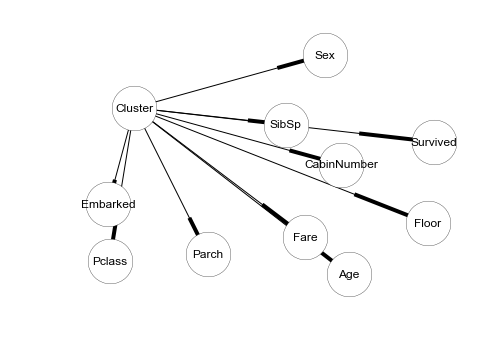

In [5]:
# write data to the temporary sqllite db
with bayespy.data.DataSet(titanic, db_folder, logger) as dataset:

    # Use a standard template, which generally gives good performance
    mixture_naive_bayes_tpl = bayespy.template.MixtureNaiveBayes(logger, discrete=discrete, continuous=continuous)
    model = bayespy.model.NetworkModel(
                        mixture_naive_bayes_tpl.create(network_factory),
                        logger)

        # result contains a bunch of metrics regarding the training step
    results = model.train(dataset)

layout = bayespy.visual.NetworkLayout(results.get_network())
graph = layout.build_graph()
pos = layout.fruchterman_reingold_layout(graph)
layout.visualise(graph, pos)
    
    
    

Finally, run the code through 3 folds to get an average score from three different models.

In [7]:
# write data to the temporary sqllite db
with bayespy.data.DataSet(titanic, db_folder, logger) as dataset:

    # Use a standard template, which generally gives good performance
    mixture_naive_bayes_tpl = bayespy.template.MixtureNaiveBayes(logger, discrete=discrete, continuous=continuous)

    k_folds = 3

    kf = KFold(titanic.shape[0], n_folds=k_folds, shuffle=True)
    score = 0
    # use cross validation to try and predict whether the individual survived or not
    for k, (train_indexes, test_indexes) in enumerate(kf):
        model = bayespy.model.NetworkModel(
                        mixture_naive_bayes_tpl.create(network_factory),
                        logger)

        # result contains a bunch of metrics regarding the training step
        model.train(dataset.subset(train_indexes))

        # note that we've not 'dropped' the target data anywhere, this will be retracted when it's queried,
        # by specifying query_options.setQueryEvidenceMode(bayesServerInference().QueryEvidenceMode.RETRACT_QUERY_EVIDENCE)
        results = model.batch_query(dataset.subset(test_indexes), bayespy.model.QueryMostLikelyState("Survived", 
                                                                            output_dtype=titanic['Survived'].dtype))

        # Each query just appends a column/ columns on to the original dataframe, so results is the same as titanic.iloc[test_indexes],
        # with (in this case) one additional column called 'Survived_maxlikelihood', joined to the original.
        score += accuracy_score(y_pred=results['Survived_maxlikelihood'].tolist(), 
                                y_true=results['Survived'].tolist())
        
print("Average score was {}. Baseline accuracy is about 0.61.".format(score / k_folds))

INFO:root:Writing 891 rows to storage
Writing 891 rows to storage
INFO:root:Finished writing 891 rows to storage
Finished writing 891 rows to storage
INFO:root:Training model...
Training model...
INFO:root:Finished training model
Finished training model
INFO:root:Using 1 processes to query 297 rows
Using 1 processes to query 297 rows
INFO:root:Queried case 0
Queried case 0
INFO:root:Training model...
Training model...
INFO:root:Finished training model
Finished training model
INFO:root:Using 1 processes to query 297 rows
Using 1 processes to query 297 rows
INFO:root:Queried case 0
Queried case 0
INFO:root:Training model...
Training model...
INFO:root:Finished training model
Finished training model
INFO:root:Using 1 processes to query 297 rows
Using 1 processes to query 297 rows
INFO:root:Queried case 0
Queried case 0


Average score was 0.7609427609427609. Baseline accuracy is about 0.61.
